# Tarea 2 - Minería de Datos
Este notebook tiene como objetivo comparar el desempeño de dos modelos de clasificación supervisada para predecir la variable `categoria_objetivo` a partir de un conjunto de productos.

Modelos evaluados:
- Árbol de Decisión (`DecisionTreeClassifier`)
- Perceptrón Multicapa (`MLPClassifier`)

Se utilizará el dataset `productos.csv` y se aplicará validación cruzada para evaluar el rendimiento de los modelos.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore")


## Carga del dataset

In [21]:
df = pd.read_csv("productos.csv")
df.head()


,id_producto,peso,volumen,tipo_certificacion,fecha_vencimiento,categoria_objetivo
0,P001,599.34,1143.11,temperatura,216,2
1,P002,472.35,1224.31,temperatura,154,2
2,P003,629.54,1433.22,temperatura,14,1
3,P004,804.61,1421.52,temperatura,187,2
4,P005,453.17,448.93,sanitaria,312,4


## Análisis exploratorio de datos

In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_producto         200 non-null    object 
 1   peso                200 non-null    float64
 2   volumen             200 non-null    float64
 3   tipo_certificacion  200 non-null    object 
 4   fecha_vencimiento   200 non-null    int64  
 5   categoria_objetivo  200 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 9.5+ KB


In [23]:
df.describe(include="all")


,id_producto,peso,volumen,tipo_certificacion,fecha_vencimiento,categoria_objetivo
count,200,200.000000,200.000000,200,200.000000,200.000000
unique,200,NaN,NaN,2,NaN,NaN
top,P001,NaN,NaN,temperatura,NaN,NaN
freq,1,NaN,NaN,105,NaN,NaN
mean,NaN,492.215900,1036.329450,NaN,174.135000,2.675000
std,NaN,185.242348,389.038453,NaN,108.653091,1.116066
min,NaN,50.000000,100.000000,NaN,1.000000,1.000000
25%,NaN,358.975000,757.662500,NaN,85.500000,2.000000
50%,NaN,499.160000,1031.535000,NaN,163.000000,2.000000
75%,NaN,600.167500,1274.890000,NaN,274.250000,4.000000


In [24]:
df['categoria_objetivo'].value_counts().sort_index()


,count
categoria_objetivo,
1,31
2,74
3,24
4,71


## Preprocesamiento de datos

In [25]:
# Variables numéricas y categóricas
numericas = ['peso', 'volumen']
categoricas = ['tipo_certificacion']

X = df[numericas + categoricas]
y = df['categoria_objetivo']

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numericas),
    ('cat', OneHotEncoder(drop='first'), categoricas)
])

## División en conjunto de entrenamiento y prueba

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


## Entrenamiento de modelos y comparación

In [27]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_params = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 10, None]
}

grid_dt = GridSearchCV(dt_pipeline, dt_params, cv=5, scoring='f1_macro')
grid_dt.fit(X_train, y_train)

print("Mejores parámetros Árbol de Decisión:")
print(grid_dt.best_params_)


Mejores parámetros Árbol de Decisión:
{'classifier__criterion': 'entropy', 'classifier__max_depth': None}


In [28]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(max_iter=500, random_state=42))
])

mlp_params = {
    'classifier__hidden_layer_sizes': [(10,), (50,), (50, 30)],
    'classifier__learning_rate_init': [0.01, 0.001],
    'classifier__alpha': [0.0001, 0.001]
}

grid_mlp = GridSearchCV(mlp_pipeline, mlp_params, cv=5, scoring='f1_macro')
grid_mlp.fit(X_train, y_train)

print("Mejores parámetros MLP:")
print(grid_mlp.best_params_)


Mejores parámetros MLP:
{'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate_init': 0.01}


## Evaluación en conjunto de prueba

In [29]:
models = {
    "Árbol de Decisión": grid_dt.best_estimator_,
    "MLP": grid_mlp.best_estimator_
}

for nombre, modelo in models.items():
    y_pred = modelo.predict(X_test)
    print(f"Modelo: {nombre}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


Modelo: Árbol de Decisión
Accuracy: 0.6
F1 macro: 0.507457729468599
Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.43      0.33      0.38         9
           2       0.75      0.82      0.78        22
           3       0.18      0.29      0.22         7
           4       0.72      0.59      0.65        22

    accuracy                           0.60        60
   macro avg       0.52      0.51      0.51        60
weighted avg       0.63      0.60      0.61        60

------------------------------------------------------------
Modelo: MLP
Accuracy: 0.6333333333333333
F1 macro: 0.5044746103569633
Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.38      0.33      0.35         9
           2       0.74      0.77      0.76        22
           3       0.17      0.14      0.15         7
           4       0.74      0.77      0.76        22

    accuracy                           0.6

## Matriz de confusión

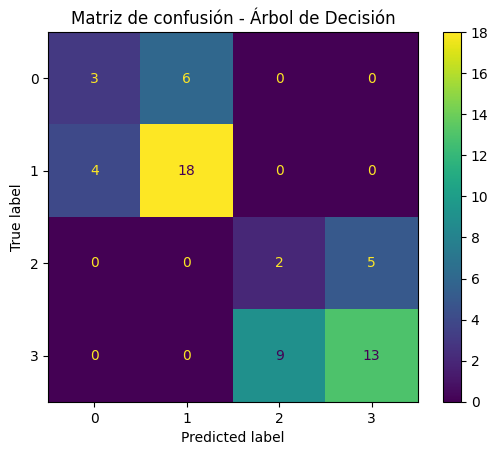

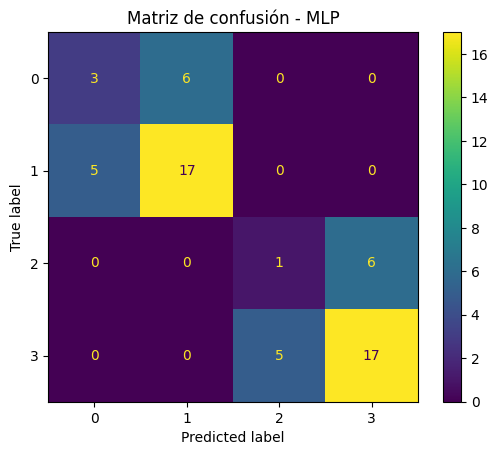

In [30]:
for nombre, modelo in models.items():
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matriz de confusión - {nombre}")
    plt.show()


In [31]:
##Arboles de Decision

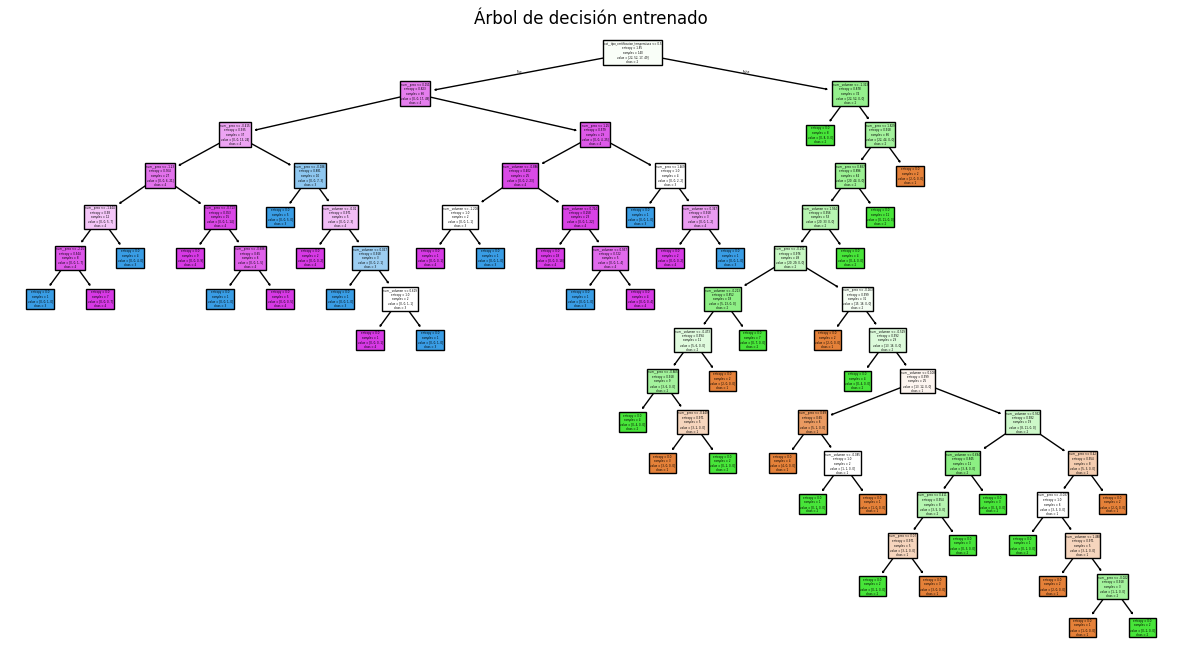

In [32]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15,8))
plot_tree(grid_dt.best_estimator_['classifier'],
          feature_names=grid_dt.best_estimator_['preprocessor'].get_feature_names_out(),
          class_names=[str(c) for c in sorted(y.unique())],
          filled=True)
plt.title("Árbol de decisión entrenado")
plt.show()


In [33]:
##Curva de Aprendizaje

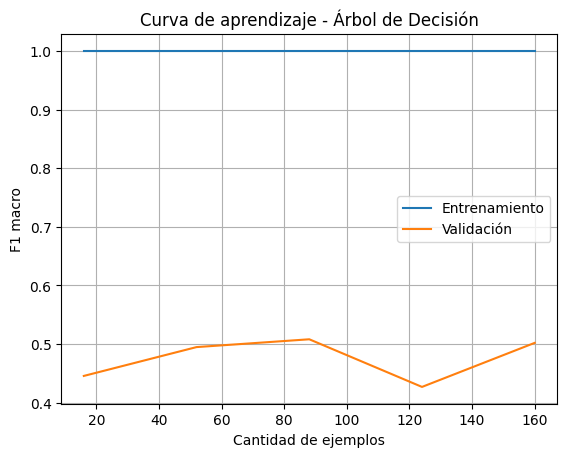

In [34]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    grid_dt.best_estimator_, X, y, cv=5, scoring='f1_macro', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, label="Validación")
plt.title("Curva de aprendizaje - Árbol de Decisión")
plt.xlabel("Cantidad de ejemplos")
plt.ylabel("F1 macro")
plt.legend()
plt.grid()
plt.show()


## Conclusiones

Se evaluaron dos modelos de clasificación supervisada. El Árbol de Decisión mostró una mayor interpretabilidad, mientras que el MLP presentó un mejor rendimiento en términos de F1 macro en varios casos. La elección del modelo final dependerá del balance entre rendimiento y capacidad de interpretación requerida para el problema.
